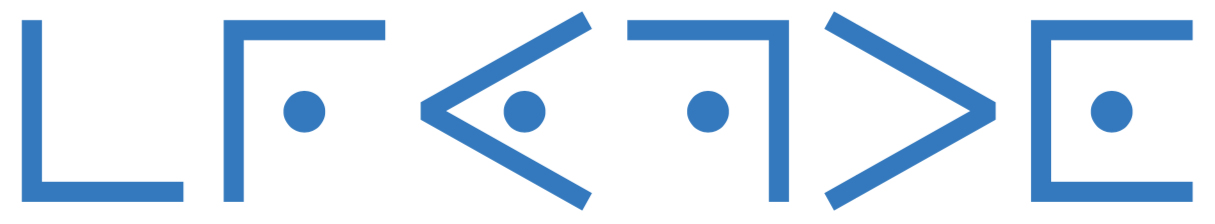

# TP2. Chiffrement symétrique, oracles et cryptanalyse

Dans ce TP nous travaillerons en Python 3, directement à l'intérieur de ce notebook jupyter.

L'objectif de cette fiche est double :
1. d'une part découvrir l'utilisation en pratique d'AES, des modes opératoires et du padding ;
2. d'autre part comprendre pourquoi la brique de chiffrement symétrique ne suffit pas à assurer la confidentialité d'un protocole de communication.

Pour illustrer le second point, nous revisitons l'attaque du _padding CBC_ vue en cours ainsi que l'attaque _chopchop_ contre le protocole WEP de chiffrement de réseau sans fil.

Nous avons choisi d'utiliser la bibliothèque [PyCryptodome](http://www.pycryptodome.org/). Pour rejouer cette fiche en dehors du TP, il  convient d'installer une version récente de [PyCryptodome](http://www.pycryptodome.org/) sur votre système.

## 1. Échauffement : bytes, XOR, AES, CBC/CTR et padding

En Python 3, les séquences d'octets sont représentées par le type ``bytes`` lorsqu'elles ne sont pas modifiables (comme des chaînes de caractères) et par le type ``bytearray`` lorsqu'elles sont modifiables (comme des listes). Le passage d'une chaîne de caractère à une séquence d'octets prend en compte le codage des caractères (par défaut on suppose que vous utilisez UTF-8 mais des arguments optionnels permettent de préciser autre chose).

In [1]:
s = "L'éléphant se dandine sur le toit."
print('s =',repr(s), len(s))
b = s.encode()
print('b =',repr(b), len(b))
x = bytes(5)
print('x =',repr(x))
y = bytes([65,66,67,68])
print('y =',repr(y))
z = bytearray(y)
z[1] += 32
print('z =',repr(z))
t = z.decode()
print('t =',repr(t))
l = list(z)
print(l)

s = "L'éléphant se dandine sur le toit." 34
b = b"L'\xc3\xa9l\xc3\xa9phant se dandine sur le toit." 36
x = b'\x00\x00\x00\x00\x00'
y = b'ABCD'
z = bytearray(b'AbCD')
t = 'AbCD'
[65, 98, 67, 68]


La bibliothèque ``Crypto`` fourni une fonction très pratique pour appliquer un masque sur une séquence d'octets.

In [2]:
from Crypto.Util.strxor import strxor

m = b"lapin"
k = b"poule"
c = strxor(m,k)
print(m,'⊕',k,'=',c)
s = strxor(c,k)
print(c,'⊕',k,'=',s)

b'lapin' ⊕ b'poule' = b'\x1c\x0e\x05\x05\x0b'
b'\x1c\x0e\x05\x05\x0b' ⊕ b'poule' = b'lapin'


✏️✏️✏️ **Question 1.**  Déchiffrer le message ``l`` ci-dessous qui a été chiffré par le chiffrement du XOR avec la clé ``CAKE``.

In [3]:
l = [1, 51, 42, 51, 44, 109, 107, 51, 44, 52, 56, 101, 48, 32, 61, 32, 57, 97, 62, 49, 42, 45, 34, 54, 38, 51, 107, 41, 38, 97, 40, 45, 42, 39, 45, 55, 38, 44, 46, 43, 55, 97, 59, 36, 49, 97, 51, 42, 49, 97, 46, 43, 99, 17, 50, 49, 43, 46, 37, 101, 98]

Il est temps de lire un peu de documentation avant de chiffrer des messages :
1. [Crypto.Cipher](https://www.pycryptodome.org/en/latest/src/cipher/cipher.html) permet de manipuler les briques de chiffrement symétrique comme ``AES`` en précisant le mode opératoire ;
2. [Crypto.Util.Padding](https://www.pycryptodome.org/en/latest/src/util/util.html#crypto-util-padding-module) permet le bourrage réversible des séquences d'octet pour obtenir des séquences de longueur multiple de la taille d'un bloc ;
3. [Crypto.Random](https://www.pycryptodome.org/en/latest/src/random/random.html) permet de générer des séquences pseudo-aléatoires de qualité cryptographique.

Voici comment chiffrer un message avec une clé et un IV aléatoire :

In [4]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from Crypto.Random import get_random_bytes

k = get_random_bytes(32)
m = b"Je code en Python et c'est ma joie."
p = pad(m,16)
cipher = AES.new(k,AES.MODE_CBC)
c = cipher.encrypt(p)
iv = cipher.iv

print("c =",repr(c))
print("k =",repr(k))
print("iv =",repr(iv))

c = b"a\xd9\xbe9\xfa\xfc\x07\xe5\xf1J\xf2\x8e<\x9f\xb3\xaf\xc4\xc1\xf4z\n\xd7-\xd2\xd5\xf7\x89\xb8\x8f\x9e-_`\x9e'\xad:(\xb6\xc1\xca\x8aBh\x04\xb4\xac\xcd"
k = b'\xebV\xae\xcf\xe9\x99\xad\x88\xaa\x1dVs\x8c\x92\xfe\x04\x9bzqH\xae\xdfU\x03\n\x80\x18Obf\xeb\xdd'
iv = b':s\x03\xfd\xd1-L\xba%nlA5\xcf\xe2\x1c'


✏️✏️✏️ **Question 2.**  Déchiffrer le message ``c`` ci-dessous, chiffré en mode CBC avec la clé ``k`` et l'IV ``iv``, à l'aide de ``Crypto.Cipher.AES`` !

In [5]:
c = b"\xcf\xbcs\xe4\xa3\xeb\x96\xa6\xe9\xa9\xd5\xf5Ob\x91\x8f\x8d9\xa2\x1f\x16\xcft\xcf\xcf\xc7\xe3\x1d\xd9'.\x81'U\xf6(\x96\xe4&\x166n3\xc5d\x94]\xf3\xb0\x98\x88\xd9\x1ew\xde\x06\xa6\x91,\x82\xd7\x06,.hJc\xd2\xe2\x1cA\xc6g\xc5IM\xd5\x059%\xa1=\xfct\x03\xdf\xc3[r\n/\xcf9\xd9\xaa\xb0"
iv = b'\x14\xb0\x8b\x0c\xc0\xe1\xa3Duj|\x0e\xf5T\xebv'
k = b"There is no cake"

✏️✏️✏️ **Question 3.**  Les deux messages ``c`` et ``d`` ci-dessous ont été chiffrés avec AES en mode CTR avec une clé inconnue. Ils sont préfixés par leur _nonce_ (l'équivalent de l'IV en mode CTR, codé ici sur 8 octets). Un indice : l'un des message commence par ``Bravo``.

In [6]:
c = b"\xe7\xa5\xfd\xe9\xd9B*\xa5iI\xc9\xbc\x9d\xe1\x85\x00'\x91/\xd2\xd8\x0b\xa3lho\xfd"
d = b'\xe7\xa5\xfd\xe9\xd9B*\xa5nC\xcb\xaf\x9e\xad\xc1N\x10\x96>\xd3\xcd]\xa0la!\xf2'
e = strxor(c,d)
print(repr(e))

b'\x00\x00\x00\x00\x00\x00\x00\x00\x07\n\x02\x13\x03LDN7\x07\x11\x01\x15V\x03\x00\tN\x0f'


## 2. Attaque padding CBC

Le code ci-dessous reproduit le protocole étudié en cours (l'envoi du message en moins) :
- ``alice`` chiffre le message à envoyer à l'aide d'AES-256-CBC après avoir appliqué le bourrage et retourne la concaténation de l'IV et du message ainsi chiffré ;
- ``bob`` déchiffre le message reçu grâce à l'IV, applique le débourrage et retourne le message déchiffré ou ``None`` si le bourrage est incorrect ;
- ``oracle`` permet de savoir si ``bob`` serait capable ou non de déchiffrer le message (c'est l'équivalent du message ACK/NACK du cours).

Le but de l'exercice est d'écrire une fonction ``attaque(c)`` capable de déchiffrer tout message ``c`` obtenu en appelant ``alice(m)`` pour un certain ``m``. Cette fonction ``attaque`` n'a pas le droit d'utiliser la clé ``k`` mais elle peut appeler la fonction ``oracle`` autant de fois qu'elle le souhaite.

In [7]:
key=get_random_bytes(32)

def alice(m):
    p=pad(m,16)
    cipher=AES.new(key,AES.MODE_CBC)
    c=cipher.iv+cipher.encrypt(p)
    return c

def bob(m):
    iv=m[:16]
    c=m[16:]
    cipher=AES.new(key,AES.MODE_CBC,iv=iv)
    p=cipher.decrypt(c)
    try:
        m=unpad(p,16)
        return m
    except ValueError:
        return None

def oracle(m):
    return bob(m) is not None

Voici un exemple d'utilisation des fonctions ``alice``, ``bob`` et ``oracle`` :

In [8]:
m=b"Coucou c'est moi !"
print("pad(m) =",pad(m,16))
c=alice(m)
print("c =",c, "(longueur :", len(c)//16,"blocs dont IV)")
print("oracle(c) =",oracle(c))
print("bob(c) =",bob(c))
d=strxor(c,bytes(len(c)-3) + b"XXX")
print("oracle(d) =",oracle(d))
print("bob(d) =",bob(d))

pad(m) = b"Coucou c'est moi !\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e\x0e"
c = b'\xb1\xfa\x0e\x18\x05\xf7\x80U\xe5\x07\xa8\x1b(iY\xabO`!$\xf2y\xd1\x8fi\xeeM}\xd7\xfc\xc9yH\x15\x87]\xe9\x07\xb2\x91\xdeG\x80\x90c\x8d2X' (longueur : 3 blocs dont IV)
oracle(c) = True
bob(c) = b"Coucou c'est moi !"
oracle(d) = False
bob(d) = None


En mode CBC, le déchiffrement du ième bloc $C_i$ chiffré d'un message en clair $M_i$ nécessite de connaître uniquement la clé $K$ et le (i-1)ème bloc chiffré $C_{i-1}$ (avec la convention $C_0=\operatorname{IV}$) :
$$
M_i = D_K(C_i) \oplus C_{i-1}
$$

Dans la suite on se concentre donc sur le déchiffrement d'un unique bloc $C$ à partir de son IV $I$ (la méthode se généralise ensuite à tout bloc $C_i$ avec l'IV $C_{i-1}$).

Si, au lieu de transmettre $I\cdot C$ à l'oracle, on lui transmet $(I\oplus\Delta)\cdot C$, l'oracle va tester si $M\oplus\Delta$ possède un bourrage valide. En effet :
$$
M \oplus \Delta = (D_K(C) \oplus I) \oplus \Delta = D_K(C) \oplus (I \oplus \Delta)
$$

Un message possède un bourrage valide si et seulement si il termine par la séquence $k k \cdots k$ qui répète $k$ fois une certaine valeur $k$.

En particulier lorsque $I\oplus \Delta$ termine par la valeur 1, l'oracle valide le message. Il suffit pour cela de modifier uniquement le dernier octet de $I$ en trouvant le bon élément parmi les 256 possible.

✏️✏️✏️ **Question 4.**  Écrire une fonction ``flip(iv,j)`` qui retourne le bloc ``iv`` reçu en entrée dans lequel le dernier octet a été remplacé par son XOR avec l'entier ``j`` (c'est à dire par ``iv[-1] ^ j``). Utiliser cette fonction pour afficher parmi les 256 valeurs possibles pour ``j`` celles pour lesquels l'oracle valide ``flip(iv,j) + b``. En déduire le dernier caractère du déchiffrement de ``b``.

In [10]:
iv=c[:16]
b=c[16:32]

def flip(c,j):
    # TODO
    pass

for j in range(256):
    # TODO
    pass

Une fois qu'on a trouvé le dernier caractère en clair de $M$, on sait comment modifier le dernier octet de $I$ pour que $I\oplus\Delta$ termine par la valeur $2$. Il suffit d'utiliser l'oracle pour trouver la modification (parmi 256) à appliquer à l'avant-dernier octet de $I$ pour que $I\oplus\Delta$ termine par le padding valide $22$. Et on itère !

✏️✏️✏️ **Question 5.** Écrire une fonction ``gnapgnap(iv,b)`` qui déchiffre le bloc ``b`` à l'aide de l'oracle. En déduire une fonction ``attaque(c)`` qui déchiffre complétement un message ``c`` produit par un certain ``alice(m)`` sans utiliser la clé.

In [11]:
def gnapgnap(iv,b):
    # TODO
    pass

print(gnapgnap(iv,b))

None


In [12]:
def attaque(c):
    # TODO
    pass

print(attaque(c))

None


## 3. Attaque ChopChop contre WEP

_Ce dernier exercice est un exercice bonus pour ceux que l'exercice précédent aurait laissés sur leur faim._

Le (désuet) protocole WEP chiffre les trames Wifi (IEEE 802.11) à l'aide de l'algorithme de chiffrement par flot RC4. Le contrôle d'intégrité est assuré par l'utilisation d'un checksum CRC32. Pour transmettre un message $M$ avec la clé secrète $K$ de 40 ou 104 bits, un IV aléatoire de 24 bits $\mbox{IV}$ est généré, le CRC32 $\operatorname{icv}(M)$ est concaténé au message $M$ et l'ensemble est masqué avec le flot RC4 généré par la concaténation de $\mbox{IV}$ et $K$ :
$$
C = (M \cdot \operatorname{icv}(M)) \oplus \operatorname{RC4}(\mbox{IV} \cdot K)
$$
La paire $\mbox{IV}\cdot C$ est alors transmise sur le réseau sans fil.

À la réception d'un message $\mbox{IV}\cdot C$ on calcule :
$$
M' \cdot J = C \oplus \operatorname{RC4}(\mbox{IV} \cdot K)
$$
Si $J = \operatorname{icv}(M')$ alors le message $M'$ est accepté. Sinon le message est rejetté silencieusement (pas d'acquittement négatif).

Ce protocole a de nombreux défauts et il est possible aujourd'hui de trouver la clé d'un réseau WEP en moins de 60s en utilisant des faiblesses statistiques de l'algorithme RC4. Nous allons nous intéresser ici à une attaque apparue à partir de 2004 et connue sous le nom _ChopChop_. Cette attaque utilise les propriétés de linéarité de CRC32 pour s'en servir comme oracle pour déchiffrer un message (et donc obtenir la séquence $\operatorname{RC4}(\mbox{IV}\cdot K)$ de longueur $|M|+4$).

Le code ci-dessous met en œuvre le calcul d'$\operatorname{icv}(M)$ :

In [13]:
crc_tab=[0]*256 
for i in range(256):
    r = i
    for j in range(8):
        if r & 1:
            r = (r>>1) ^ 0xedb88320
        else:
            r >>= 1
    crc_tab[i ^ 0xff] = r ^ 0xff000000

def crc32(buf, crc=0):
    for k in buf:
        crc = (crc >> 8) ^ crc_tab[(crc & 0xff) ^ k] 
    return crc

def lsb(x,k=4):
    r=[]
    for i in range(k):
        r.append(x & 0xff)
        x>>=8
    return bytes(r)

def icv(buf):
    return lsb(crc32(buf))

Nous allons reproduire la même attaque en remplaçant RC4 par AES-256-CTR, qui est aussi un chiffrement par flot. Le code ci-dessous met en œuvre ce protocole sous la forme de deux fonctions ``alice`` et ``bob`` et une fonction ``oracle``.

In [14]:
def nonce(): 
    return get_random_bytes(8)

def alice(m):
    no=nonce()
    mc=m + icv(m)
    ci=AES.new(key,AES.MODE_CTR,nonce=no)
    return no + ci.encrypt(mc)

def bob(c):
    no=c[:8]
    ci=AES.new(key,AES.MODE_CTR,nonce=no)
    mc=ci.decrypt(c[8:])
    ic=mc[-4:]
    m=mc[:-4]
    if icv(m) == ic:
        return m
    else:
        return None

def oracle(c):
    return bob(c) is not None

Voici un exemple d'utilisation des fonctions ``alice``, ``bob`` et ``oracle`` :

In [15]:
m=b"Tranchez leur la tete !"
c=alice(m)
print("c =",c)
print("oracle(c) =",oracle(c))
print("bob(c) =",bob(c))
d=strxor(c,b"XXX" + bytes(len(c)-3))
print("oracle(d) =",oracle(d))
print("bob(d) =",bob(d))

c = b'\xffq\x14\x83\x17h\xfd\x10v\xebs\xdf\x8b,\x94#*\x1b\xb1"\x9b\x9b\xd6\xdc\x19W#\xdd\xf8(\xdb\xe3\xb7{\xf0'
oracle(c) = True
bob(c) = b'Tranchez leur la tete !'
oracle(d) = False
bob(d) = None


L'attaque consiste à transformer le chiffrement $C = C_1 C_2 \cdots C_{n+4}$ d'un message $M = M_1 M_2 \cdots M_n$ en un chiffré valide $D = D_1 D_2 \cdots D_{n+3}$ du message tronqué $M' = M_1 M_2 \cdots M_{n-1}$ en utilisant l'oracle pour faire un choix parmi 256 (comme dans l'attaque de l'exercice précédent). 

Notons $K = K_1 K_2 \cdots K_{n+4}$ le masque, $I = \operatorname{icv}(M)$ et $J = \operatorname{icv}(M')$. Alors on a les égalités suivantes :
$$
\begin{array}{cccccccccc}
& M_1 & M_2 & \cdots & M_{n-1} & M_n & I_1 & I_2 & I_3 & I_4\\
\oplus & K_1 & K_2 & \cdots & K_{n-1} & K_n & K_{n+1} & K_{n+2} & K_{n+3} & K_{n+4}\\\hline
& C_1 & C_2 & \cdots & C_{n-1} & C_n & C_{n+1} & C_{n+2} & C_{n+3} & C_{n+4}
\end{array}
$$
et
$$
\begin{array}{ccccccccccc}
& M_1 & M_2 & \cdots & M_{n-1} & J_1 & J_2 & J_3 & J_4 & \phantom{I_4}\\
\oplus & K_1 & K_2 & \cdots & K_{n-1} & K_n & K_{n+1} & K_{n+2} & K_{n+3} & \phantom{K_{n+4}}\\\hline
& D_1 & D_2 & \cdots & D_{n-1} & D_n & D_{n+1} & D_{n+2} & D_{n+3} & \phantom{D_{n+4}}
\end{array}
$$

Les $n-1$ premières valeurs de $D_i$ sont égales aux $C_i$. Notons $X$ la modification à apporter à $C_n$ pour obtenir $D_n$, _i.e._ $X = C_n \oplus D_n = M_n \oplus J_1$.

✏️✏️✏️ **Question 6.** En étudiant le code de CRC32, montrer comment calculer $D_{n+1}$, $D_{n+2}$, $D_{n+3}$ et $K_{n+4}$ à partir de $X$. On pourra commencer par chercher comment calculer $I$ à partir de $J$.

✏️✏️✏️ **Question 7.** Écrire une fonction ``chop(c)`` qui à partir d'un message chiffré $C$ retourne une paire ``(d,x)`` où ``d`` est le chiffré du message tronqué $D$ et ``k`` le dernier octet du masque $K_{n+4}$.

In [16]:
def chop(c):
    # TODO
    pass

print(chop(c))

None


✏️✏️✏️ **Question 8.** En déduire une fonction ``chopchop(c)`` qui déchiffre un message chiffré généré par ``alice(m)`` sans utiliser la clé secrète mais en utilisant l'oracle.

In [17]:
def chopchop(c):
    # TODO
    pass

print(chopchop(c))

None
